In [1]:
import nilearn.image as ni
import nibabel as nb
from nilearn.plotting import plot_anat, plot_prob_atlas, show, plot_stat_map
import SimpleITK as sitk
from utils import pad_nifti_image, multires_registration, interpolate_zeros
from aligner import Aligner
from warp_utils import apply_warp
import numpy as np
from monai.transforms import LoadImage, EnsureChannelFirst
from warper import Warper


# %matplotlib notebook
# import gui


/home/codespace/.python/current/lib/python3.10/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: The following kwargs were not used by contour: 'color'
  im = getattr(ax, type)(data_2d.copy(),


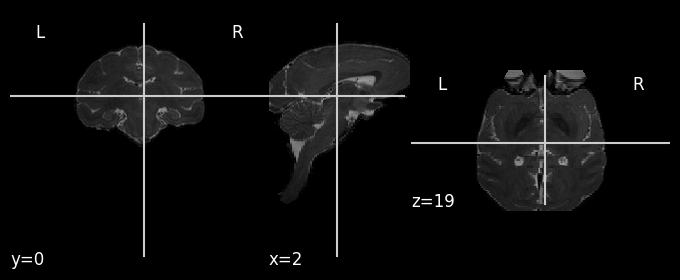

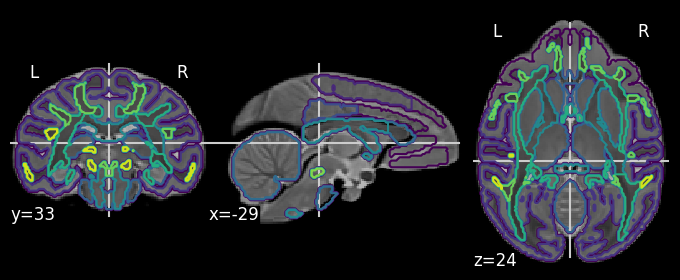

In [15]:
sub_t2 = "/deneb_disk/macaque_atlas_data/test_data/MAC10_pad.nii.gz"
sub_bse_t2_orig = "/deneb_disk/macaque_atlas_data/test_data/MAC10.bse.nii.gz"
sub_bse_t2 = "/deneb_disk/macaque_atlas_data/test_data/MAC10_pad.bse.nii.gz"
sub_mask_t2_orig = "/deneb_disk/macaque_atlas_data/test_data/MAC10.mask.nii.gz"
sub_mask_t2 = "/deneb_disk/macaque_atlas_data/test_data/MAC10_pad.mask.nii.gz"

atlas_bse_t2 = "/deneb_disk/macaque_atlas_data/macaque_atlas/ONPRC18_atlas_v1/ONPRC18_Templates/ONPRC18_T2W_brain.nii.gz"
atlas_labels = "/deneb_disk/macaque_atlas_data/macaque_atlas/ONPRC18_atlas_v1/ONPRC18_Labelmaps/ONPRC18_GrayMatterWhiteMatterLabelmap.nii.gz"

centered_atlas = "/deneb_disk/macaque_atlas_data/test_data/atlas.nii.gz"
centered_atlas_labels = "/deneb_disk/macaque_atlas_data/test_data/atlas.label.nii.gz"

lin_reg_map_file = "/deneb_disk/macaque_atlas_data/test_data/lin_ddf.nii.gz"
centered_atlas_linreg = "/deneb_disk/macaque_atlas_data/test_data/atlas_lin.nii.gz"
centered_atlas_linreg_labels = (
    "/deneb_disk/macaque_atlas_data/test_data/atlas_lin.label.nii.gz"
)

nonlin_reg_map_file = "/deneb_disk/macaque_atlas_data/test_data/nonlin_ddf.nii.gz"
centered_atlas_nonlinreg = (
    "/deneb_disk/macaque_atlas_data/test_data/atlas_nonlin.nii.gz"
)
centered_atlas_nonlinreg_labels = (
    "/deneb_disk/macaque_atlas_data/test_data/atlas_nonlin.label.nii.gz"
)
centered_atlas_nonlinreg_labels_filled = (
    "/deneb_disk/macaque_atlas_data/test_data/atlas_nonlin_filled.label.nii.gz"
)
jac_det_file = "/deneb_disk/macaque_atlas_data/test_data/jacobian_det.nii.gz"

PAD = 10

plot_anat(sub_bse_t2_orig)
d = plot_anat(atlas_bse_t2)
d.add_contours(atlas_labels, color="r")


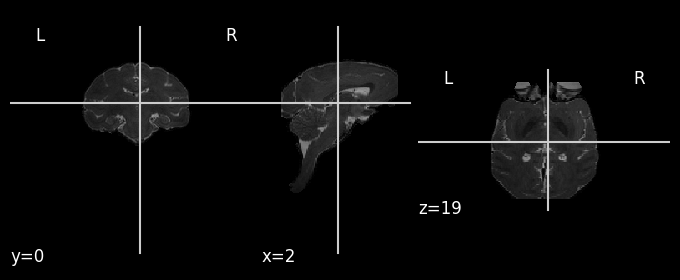

In [3]:
pad_nifti_image(sub_bse_t2_orig, sub_bse_t2, PAD)
pad_nifti_image(sub_mask_t2_orig, sub_mask_t2, PAD)
plot_anat(sub_bse_t2)


Final metric value: -0.4867084562245786
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 15.


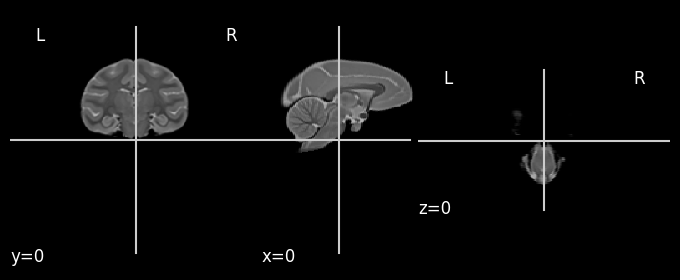

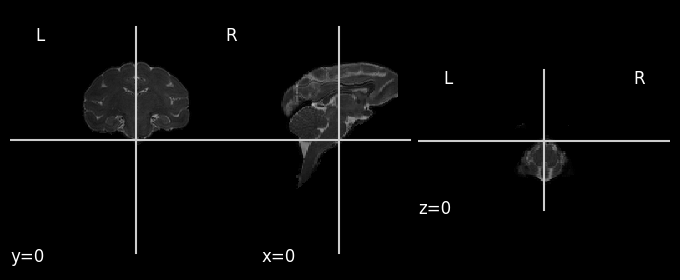

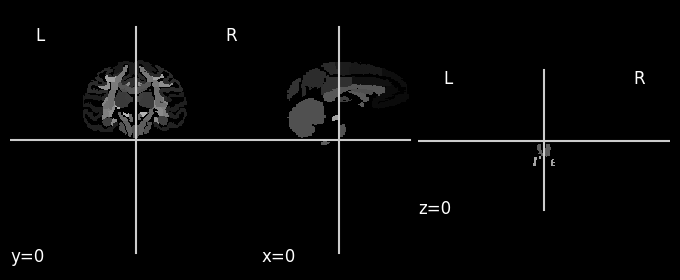

In [4]:
fixed_image = sitk.ReadImage(sub_bse_t2, sitk.sitkFloat32)
moving_image = sitk.ReadImage(atlas_bse_t2, sitk.sitkFloat32)
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

final_transform, _ = multires_registration(
    fixed_image, moving_image, initial_transform)

moved_image = sitk.Resample(moving_image, fixed_image, final_transform)

sitk.WriteImage(moved_image, centered_atlas)

moving_image = sitk.ReadImage(atlas_labels, sitk.sitkUInt16)
moved_image = sitk.Resample(
    moving_image,
    fixed_image,
    transform=final_transform,
    interpolator=sitk.sitkNearestNeighbor,
)
sitk.WriteImage(moved_image, centered_atlas_labels)


plot_anat(centered_atlas, cut_coords=(0, 0, 0))
plot_anat(sub_bse_t2, cut_coords=(0, 0, 0))
plot_anat(centered_atlas_labels, cut_coords=(0, 0, 0))

show()


/home/codespace/.python/current/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.array LoadImage.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/home/codespace/.python/current/lib/python3.10/site-packages/monai/networks/blocks/warp.py:67: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")


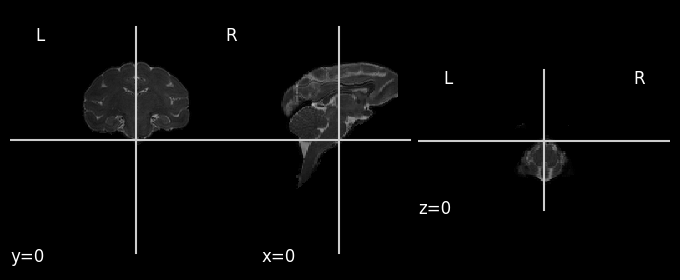

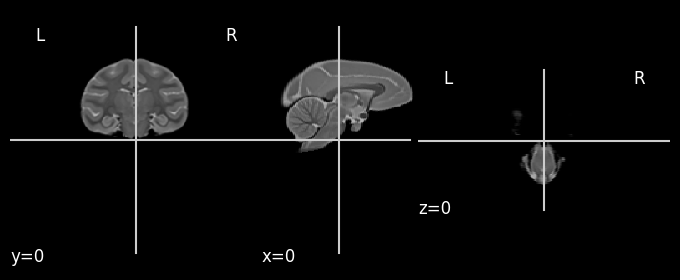

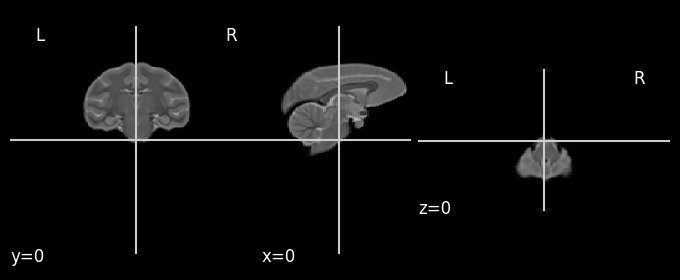

In [5]:
aligner = Aligner()
aligner.affine_reg(
    fixed_file=sub_bse_t2,
    moving_file=centered_atlas,
    output_file=centered_atlas_linreg,
    ddf_file=lin_reg_map_file,
    loss="cc",
)

plot_anat(sub_bse_t2, cut_coords=(0, 0, 0))
plot_anat(centered_atlas, cut_coords=(0, 0, 0))
plot_anat(centered_atlas_linreg, cut_coords=(0, 0, 0))


In [6]:
disp_field, meta = LoadImage()(lin_reg_map_file)
disp_field = EnsureChannelFirst()(disp_field)
print(disp_field.shape)

at1, meta = LoadImage()(centered_atlas_labels)
at_lab = EnsureChannelFirst()(at1)
print(at_lab.shape)

warped_lab = apply_warp(
    disp_field[None,], at_lab[None,], at_lab[None,], interp_mode="nearest"
)
nb.save(
    nb.Nifti1Image(warped_lab[0, 0].detach().cpu().numpy(), at_lab.affine),
    centered_atlas_linreg_labels,
)


torch.Size([3, 302, 106, 302])
torch.Size([1, 302, 106, 302])


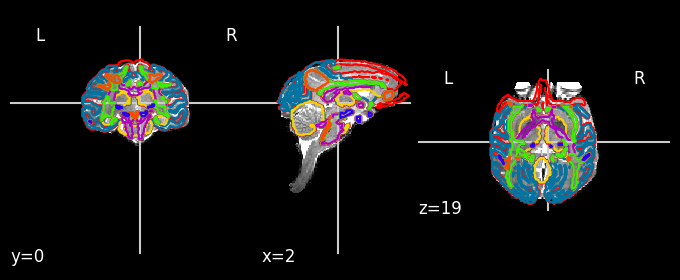

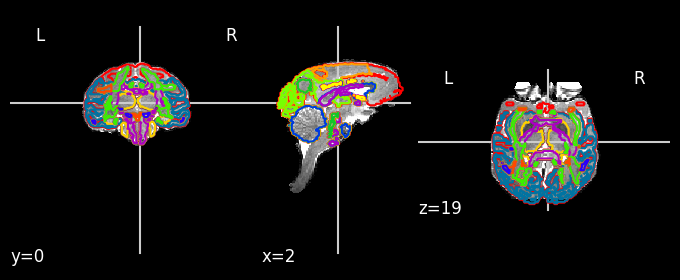

In [7]:
d = plot_anat(sub_bse_t2, vmax=1400)
d.add_contours(centered_atlas_labels, cmap="prism")
d = plot_anat(sub_bse_t2, vmax=1400)
d.add_contours(centered_atlas_linreg_labels, cmap="prism")


In [8]:
nonlin_reg = Warper()
nonlin_reg.nonlinear_reg(
    target_file=sub_bse_t2,
    moving_file=centered_atlas_linreg,
    output_file=centered_atlas_nonlinreg,
    ddf_file=nonlin_reg_map_file,
    reg_penalty=1,
    nn_input_size=64,
    lr=1e-4,
    max_epochs=5000,
    loss="cc",
    jacobian_determinant_file=jac_det_file,
)


optimizing
finished  5000  epochs93m -0.04  



computing deformation field
applying warp
saving warped output: /deneb_disk/macaque_atlas_data/test_data/atlas_nonlin.nii.gz
saving ddf: /deneb_disk/macaque_atlas_data/test_data/nonlin_ddf.nii.gz


In [9]:
disp_field, meta = LoadImage()(nonlin_reg_map_file)
disp_field = EnsureChannelFirst()(disp_field)
print(disp_field.shape)

at1, meta = LoadImage()(centered_atlas_linreg_labels)
at_lab = EnsureChannelFirst()(at1)
print(at_lab.shape)

warped_lab = apply_warp(
    disp_field[None,], at_lab[None,], at_lab[None,], interp_mode="nearest"
)
nb.save(
    nb.Nifti1Image(
        np.uint16(warped_lab[0, 0].detach().cpu().numpy()), at_lab.affine),
    centered_atlas_nonlinreg_labels,
)


torch.Size([3, 302, 106, 302])
torch.Size([1, 302, 106, 302])


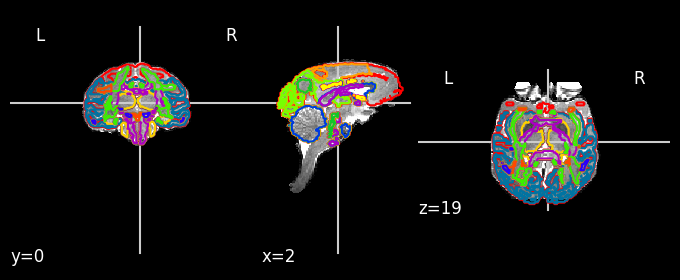

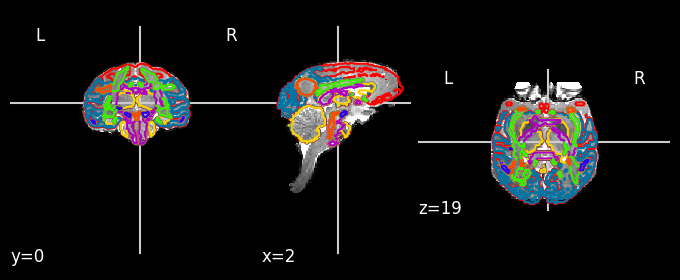

In [10]:
d = plot_anat(sub_bse_t2, vmax=1400)
d.add_contours(centered_atlas_linreg_labels, cmap="prism")
d = plot_anat(sub_bse_t2, vmax=1400)
d.add_contours(centered_atlas_nonlinreg_labels, cmap="prism")


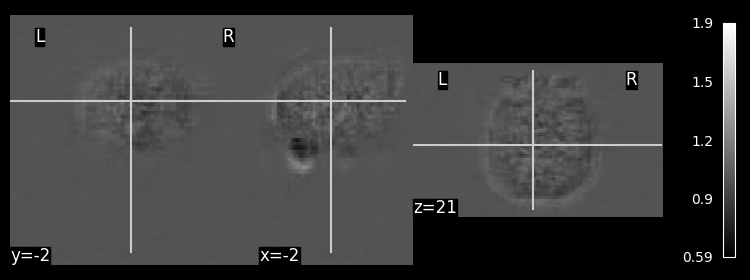

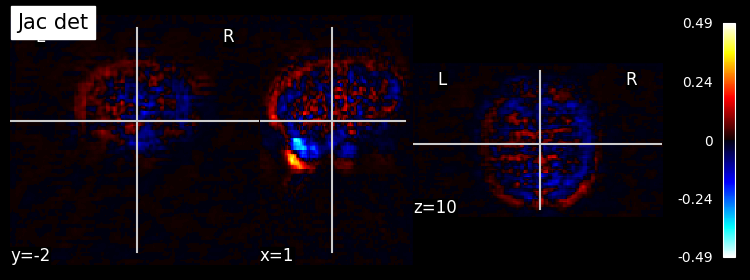

In [11]:
plot_anat(jac_det_file, colorbar=True)

jac=nb.load(jac_det_file)
jac = jac.get_fdata() - 1

from nilearn.image import new_img_like
jac = new_img_like(sub_bse_t2,jac)
plot_stat_map(jac,sub_bse_t2,title='Jac det')

Fill the gaps between the segmentations within the brain mask

In [12]:

# Load the NIfTI image

image_path = centered_atlas_nonlinreg_labels
mask_path = sub_mask_t2
image = nb.load(image_path)
mask = nb.load(mask_path)

image_data = image.get_fdata()
mask_data = mask.get_fdata()

# Interpolate zeros in the image data
interpolated_data = interpolate_zeros(image_data, mask_data)

# Save the interpolated image as a new NIfTI file
interpolated_image = nb.Nifti1Image(interpolated_data, image.affine)
nb.save(interpolated_image, centered_atlas_nonlinreg_labels_filled)


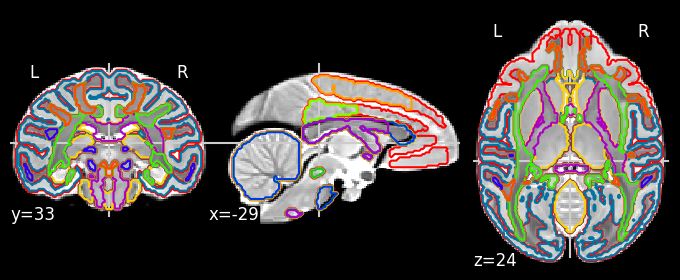

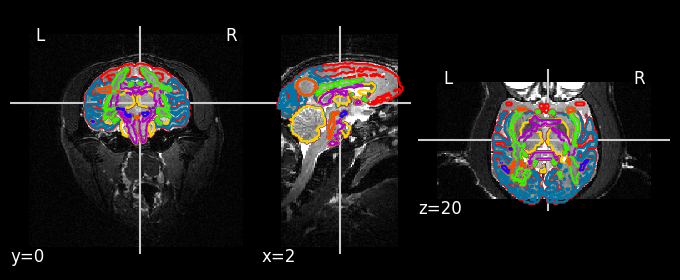

In [20]:
d = plot_anat(atlas_bse_t2,vmax=3.6)
d.add_contours(atlas_labels, cmap="prism")

d = plot_anat(sub_t2, vmax=1400)
d.add_contours(centered_atlas_nonlinreg_labels, cmap="prism")


Dataset created in /home/codespace/nilearn_data/fsaverage



Downloaded 27287552 of 34242788 bytes (79.7%,    0.5s remaining) ...done. (4 seconds, 0 min)
Extracting data from /home/codespace/nilearn_data/fsaverage/735bf0f211246c83396b5f21f706c224/download..... done.
/home/codespace/.python/current/lib/python3.10/site-packages/nilearn/surface/surface.py:460: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


ValueError: cannot convert float NaN to integer